# Week 14 - Day 1: RNN Fundamentals for Trading

## Learning Objectives
- Understand why sequential data is crucial in finance
- Master RNN architecture and information flow
- Recognize the vanishing gradient problem and its implications
- Implement a simple RNN from scratch and using PyTorch
- Build a practical SPY price prediction model

---

## 1. Sequential Data Importance in Finance

### Why Sequence Matters

Financial markets are inherently **sequential** - the order of events matters:

| Data Type | Sequential Nature | Example |
|-----------|-------------------|--------|
| Price Series | Temporal dependencies | Today's price depends on yesterday's |
| Order Flow | Sequence of trades | Buy-sell patterns indicate momentum |
| News Events | Causal chains | Fed announcement → Market reaction |
| Technical Patterns | Pattern recognition | Head & shoulders forms over time |

### Traditional ML Limitations

Traditional ML models treat each observation independently:

```
Traditional ML:  [X₁] → Model → ŷ₁
                 [X₂] → Model → ŷ₂  (No memory of X₁!)
                 [X₃] → Model → ŷ₃

RNN:            [X₁] → RNN(h₀) → ŷ₁, h₁
                [X₂] → RNN(h₁) → ŷ₂, h₂  (Carries memory!)
                [X₃] → RNN(h₂) → ŷ₃, h₃
```

### Key Insight for Trading
> "Markets have memory" - Past price movements, volume patterns, and sentiment influence future behavior. RNNs can learn these temporal dependencies.

In [1]:
# Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.9.1


AttributeError: 'DataFrame' object has no attribute 'autocorr'

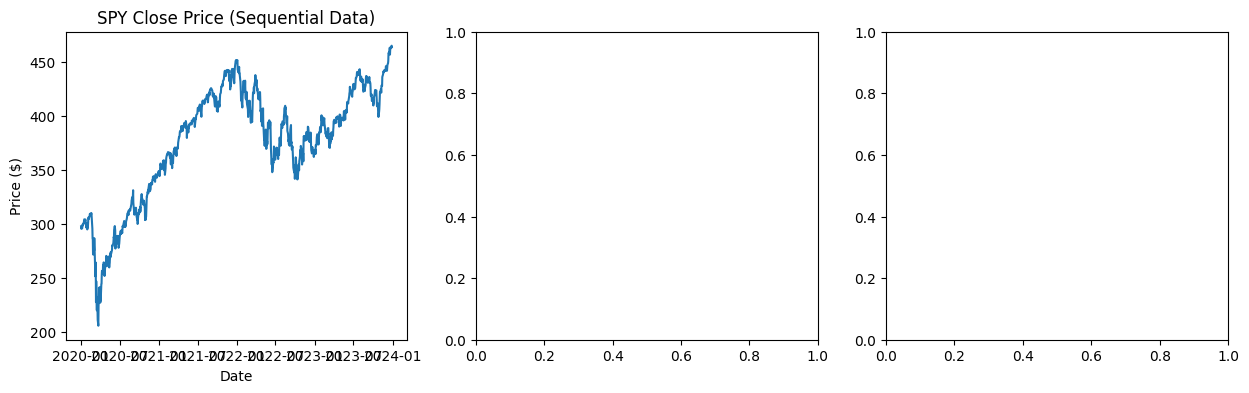

In [2]:
# Demonstrate sequential dependencies in SPY
spy = yf.download('SPY', start='2020-01-01', end='2024-01-01', progress=False)
spy_close = spy['Close'].dropna()

# Calculate autocorrelation to show temporal dependencies
returns = spy_close.pct_change().dropna()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Price series
axes[0].plot(spy_close.index, spy_close.values)
axes[0].set_title('SPY Close Price (Sequential Data)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price ($)')

# Plot 2: Autocorrelation of returns
lags = range(1, 21)
autocorrs = [returns.autocorr(lag=i) for i in lags]
axes[1].bar(lags, autocorrs, color='steelblue', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].axhline(y=1.96/np.sqrt(len(returns)), color='red', linestyle='--', label='95% CI')
axes[1].axhline(y=-1.96/np.sqrt(len(returns)), color='red', linestyle='--')
axes[1].set_title('Return Autocorrelation (Temporal Dependencies)')
axes[1].set_xlabel('Lag (days)')
axes[1].set_ylabel('Autocorrelation')
axes[1].legend()

# Plot 3: Rolling volatility (shows regime persistence)
rolling_vol = returns.rolling(21).std() * np.sqrt(252)
axes[2].plot(rolling_vol.index, rolling_vol.values, color='orange')
axes[2].set_title('21-Day Rolling Volatility (Regime Persistence)')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Annualized Volatility')

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print(f"- Price series shows clear trends and mean-reversion patterns")
print(f"- Autocorrelation shows weak but present dependencies in returns")
print(f"- Volatility clustering: high vol follows high vol (ARCH effects)")

---
## 2. RNN Architecture

### Core Concept: Hidden State

The RNN maintains a **hidden state** that acts as memory:

```
┌─────────────────────────────────────────────────────────────┐
│                    RNN UNROLLED IN TIME                     │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│    ┌────┐      ┌────┐      ┌────┐      ┌────┐              │
│    │ hₜ │ ──── │ hₜ │ ──── │ hₜ │ ──── │ hₜ │              │
│    └────┘      └────┘      └────┘      └────┘              │
│      │           │           │           │                  │
│      ▼           ▼           ▼           ▼                  │
│    ┌────┐      ┌────┐      ┌────┐      ┌────┐              │
│    │ ŷ₁ │      │ ŷ₂ │      │ ŷ₃ │      │ ŷ₄ │              │
│    └────┘      └────┘      └────┘      └────┘              │
│      ▲           ▲           ▲           ▲                  │
│    ┌────┐      ┌────┐      ┌────┐      ┌────┐              │
│    │RNN │      │RNN │      │RNN │      │RNN │ (Same weights)│
│    └────┘      └────┘      └────┘      └────┘              │
│      ▲           ▲           ▲           ▲                  │
│    ┌────┐      ┌────┐      ┌────┐      ┌────┐              │
│    │ x₁ │      │ x₂ │      │ x₃ │      │ x₄ │              │
│    └────┘      └────┘      └────┘      └────┘              │
│   Price₁      Price₂      Price₃      Price₄               │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

### Mathematical Formulation

At each timestep $t$:

$$h_t = \tanh(W_{hh} \cdot h_{t-1} + W_{xh} \cdot x_t + b_h)$$

$$\hat{y}_t = W_{hy} \cdot h_t + b_y$$

Where:
- $x_t$ = Input at time $t$ (e.g., today's price features)
- $h_t$ = Hidden state at time $t$ (memory)
- $\hat{y}_t$ = Output prediction at time $t$
- $W_{hh}, W_{xh}, W_{hy}$ = Weight matrices (shared across time!)
- $\tanh$ = Activation function (squashes values to [-1, 1])

In [ ]:
# Visualize RNN architecture and information flow
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Single RNN Cell
ax1 = axes[0]
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.axis('off')
ax1.set_title('Single RNN Cell', fontsize=14, fontweight='bold')

# Draw RNN cell box
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
cell = FancyBboxPatch((3, 3), 4, 4, boxstyle="round,pad=0.1", 
                       facecolor='lightblue', edgecolor='navy', linewidth=2)
ax1.add_patch(cell)
ax1.text(5, 5, 'RNN\nCell', ha='center', va='center', fontsize=12, fontweight='bold')

# Input arrow
ax1.annotate('', xy=(5, 3), xytext=(5, 1),
            arrowprops=dict(arrowstyle='->', color='green', lw=2))
ax1.text(5, 0.5, '$x_t$ (Input)', ha='center', fontsize=11, color='green')

# Output arrow
ax1.annotate('', xy=(5, 9), xytext=(5, 7),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax1.text(5, 9.5, '$\hat{y}_t$ (Output)', ha='center', fontsize=11, color='red')

# Hidden state arrows
ax1.annotate('', xy=(3, 5), xytext=(1, 5),
            arrowprops=dict(arrowstyle='->', color='purple', lw=2))
ax1.text(0.5, 5.5, '$h_{t-1}$', ha='center', fontsize=11, color='purple')

ax1.annotate('', xy=(9, 5), xytext=(7, 5),
            arrowprops=dict(arrowstyle='->', color='purple', lw=2))
ax1.text(9.5, 5.5, '$h_t$', ha='center', fontsize=11, color='purple')

# Right: Unrolled RNN
ax2 = axes[1]
ax2.set_xlim(0, 14)
ax2.set_ylim(0, 10)
ax2.axis('off')
ax2.set_title('RNN Unrolled Through Time (3 timesteps)', fontsize=14, fontweight='bold')

positions = [2, 6, 10]
for i, pos in enumerate(positions):
    # Cell
    cell = FancyBboxPatch((pos-1, 4), 2, 2, boxstyle="round,pad=0.05",
                          facecolor='lightblue', edgecolor='navy', linewidth=2)
    ax2.add_patch(cell)
    ax2.text(pos, 5, f'RNN', ha='center', va='center', fontsize=10)
    
    # Input
    ax2.annotate('', xy=(pos, 4), xytext=(pos, 2),
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5))
    ax2.text(pos, 1.5, f'$x_{i+1}$', ha='center', fontsize=10, color='green')
    
    # Output
    ax2.annotate('', xy=(pos, 8), xytext=(pos, 6),
                arrowprops=dict(arrowstyle='->', color='red', lw=1.5))
    ax2.text(pos, 8.5, f'$\hat{{y}}_{i+1}$', ha='center', fontsize=10, color='red')

# Hidden state connections
for i in range(len(positions)-1):
    ax2.annotate('', xy=(positions[i+1]-1, 5), xytext=(positions[i]+1, 5),
                arrowprops=dict(arrowstyle='->', color='purple', lw=2))
    ax2.text((positions[i]+positions[i+1])/2, 5.5, f'$h_{i+1}$', 
            ha='center', fontsize=10, color='purple')

# Initial hidden state
ax2.annotate('', xy=(positions[0]-1, 5), xytext=(0, 5),
            arrowprops=dict(arrowstyle='->', color='purple', lw=2))
ax2.text(0, 5.5, '$h_0$', ha='center', fontsize=10, color='purple')

plt.tight_layout()
plt.show()

In [ ]:
# Implement RNN Cell from Scratch
class SimpleRNNCell:
    """A simple RNN cell implemented from scratch for educational purposes."""
    
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Xavier initialization
        scale_xh = np.sqrt(2.0 / (input_size + hidden_size))
        scale_hh = np.sqrt(2.0 / (hidden_size + hidden_size))
        
        # Weight matrices
        self.W_xh = np.random.randn(input_size, hidden_size) * scale_xh  # Input to hidden
        self.W_hh = np.random.randn(hidden_size, hidden_size) * scale_hh  # Hidden to hidden
        self.b_h = np.zeros((1, hidden_size))  # Hidden bias
        
    def forward(self, x, h_prev):
        """
        Forward pass for single timestep.
        
        Args:
            x: Input at current timestep (batch_size, input_size)
            h_prev: Previous hidden state (batch_size, hidden_size)
            
        Returns:
            h_new: New hidden state (batch_size, hidden_size)
        """
        # h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b_h)
        h_new = np.tanh(np.dot(x, self.W_xh) + np.dot(h_prev, self.W_hh) + self.b_h)
        return h_new
    
    def forward_sequence(self, X):
        """
        Process entire sequence.
        
        Args:
            X: Input sequence (batch_size, seq_length, input_size)
            
        Returns:
            hidden_states: All hidden states (batch_size, seq_length, hidden_size)
        """
        batch_size, seq_length, _ = X.shape
        h = np.zeros((batch_size, self.hidden_size))  # Initial hidden state
        
        hidden_states = []
        for t in range(seq_length):
            h = self.forward(X[:, t, :], h)
            hidden_states.append(h)
            
        return np.stack(hidden_states, axis=1)

# Demonstrate
rnn_cell = SimpleRNNCell(input_size=1, hidden_size=4)

# Create sample sequence (5 days of normalized prices)
sample_seq = np.array([[[0.1], [0.15], [0.12], [0.18], [0.22]]])  # (1, 5, 1)
hidden_states = rnn_cell.forward_sequence(sample_seq)

print("Input sequence shape:", sample_seq.shape)
print("Hidden states shape:", hidden_states.shape)
print("\nHidden state evolution through time:")
for t in range(5):
    print(f"  t={t}: h = {hidden_states[0, t, :].round(3)}")

---
## 3. The Vanishing Gradient Problem

### Why RNNs Struggle with Long Sequences

During backpropagation through time (BPTT), gradients must flow backwards through many timesteps:

```
GRADIENT FLOW IN BACKPROPAGATION:

Loss at t=T
    │
    ▼
∂L/∂h_T → ∂h_T/∂h_{T-1} → ∂h_{T-1}/∂h_{T-2} → ... → ∂h_2/∂h_1
           ╲_____________________________________________╱
                    Multiply W_hh many times!
```

### The Math Behind the Problem

The gradient of loss w.r.t. early hidden states involves:

$$\frac{\partial L}{\partial h_1} = \frac{\partial L}{\partial h_T} \cdot \prod_{t=2}^{T} \frac{\partial h_t}{\partial h_{t-1}}$$

Where each term involves $W_{hh}$ and $\tanh'$:

$$\frac{\partial h_t}{\partial h_{t-1}} = W_{hh}^T \cdot \text{diag}(1 - h_t^2)$$

**Problem**: If eigenvalues of $W_{hh}$ are:
- **< 1**: Gradients shrink exponentially → **Vanishing gradients**
- **> 1**: Gradients grow exponentially → **Exploding gradients**

In [ ]:
# Demonstrate Vanishing Gradient Problem
def simulate_gradient_flow(W_hh, seq_length):
    """
    Simulate how gradients decay/grow through an RNN.
    
    Simplified: assumes tanh derivative ≈ 1 (linear regime)
    In practice, tanh' ∈ (0, 1], making vanishing worse.
    """
    gradient_norms = [1.0]  # Initial gradient magnitude
    
    for t in range(1, seq_length):
        # Gradient at t-1 = gradient at t * W_hh
        # Norm scales by largest singular value of W_hh
        singular_values = np.linalg.svd(W_hh, compute_uv=False)
        max_sv = np.max(singular_values)
        gradient_norms.append(gradient_norms[-1] * max_sv * 0.8)  # 0.8 accounts for tanh'
    
    return gradient_norms[::-1]  # Reverse to show flow from end to start

# Test with different weight matrices
hidden_size = 10
seq_length = 50

# Scenario 1: Small weights → Vanishing
W_small = np.random.randn(hidden_size, hidden_size) * 0.3
grads_vanishing = simulate_gradient_flow(W_small, seq_length)

# Scenario 2: Orthogonal weights → Stable
W_ortho, _ = np.linalg.qr(np.random.randn(hidden_size, hidden_size))
grads_stable = simulate_gradient_flow(W_ortho, seq_length)

# Scenario 3: Large weights → Exploding
W_large = np.random.randn(hidden_size, hidden_size) * 1.5
grads_exploding = simulate_gradient_flow(W_large, seq_length)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].plot(grads_vanishing, label='Small W (σ=0.3)', color='blue', linewidth=2)
axes[0].plot(grads_stable, label='Orthogonal W', color='green', linewidth=2)
axes[0].plot(grads_exploding[:30], label='Large W (σ=1.5)', color='red', linewidth=2)
axes[0].set_xlabel('Timesteps from Loss')
axes[0].set_ylabel('Gradient Magnitude')
axes[0].set_title('Gradient Flow Through Time (Linear Scale)')
axes[0].legend()
axes[0].set_xlim(0, 50)

# Log scale
axes[1].semilogy(grads_vanishing, label='Vanishing', color='blue', linewidth=2)
axes[1].semilogy(grads_stable, label='Stable', color='green', linewidth=2)
axes[1].semilogy(grads_exploding, label='Exploding', color='red', linewidth=2)
axes[1].set_xlabel('Timesteps from Loss')
axes[1].set_ylabel('Gradient Magnitude (log)')
axes[1].set_title('Gradient Flow Through Time (Log Scale)')
axes[1].legend()
axes[1].axhline(y=1e-6, color='gray', linestyle='--', alpha=0.5)
axes[1].text(35, 2e-6, 'Effective zero', color='gray')

plt.tight_layout()
plt.show()

print("\n📉 Implications for Trading:")
print(f"- Vanishing: RNN forgets patterns older than ~10-20 steps")
print(f"- This means ~2-4 weeks of daily data memory at best")
print(f"- Solution: LSTM/GRU (Week 14, Day 2-3) solve this problem!")

In [ ]:
# Practical demonstration: tanh derivative compounds the problem
x = np.linspace(-3, 3, 100)
tanh_val = np.tanh(x)
tanh_deriv = 1 - np.tanh(x)**2

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# tanh and derivative
axes[0].plot(x, tanh_val, label='tanh(x)', linewidth=2)
axes[0].plot(x, tanh_deriv, label="tanh'(x) = 1 - tanh²(x)", linewidth=2)
axes[0].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[0].axhline(y=1, color='gray', linestyle='--', alpha=0.3)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('tanh Activation and Its Derivative')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Product of derivatives
n_steps = np.arange(1, 51)
# Assume hidden values spread around tanh'(x) ≈ 0.5 on average
avg_derivs = [0.9, 0.7, 0.5, 0.3]
for deriv in avg_derivs:
    product = deriv ** n_steps
    axes[1].semilogy(n_steps, product, label=f"tanh' ≈ {deriv}", linewidth=2)

axes[1].set_xlabel('Number of Timesteps')
axes[1].set_ylabel('Cumulative Gradient Factor (log)')
axes[1].set_title('Gradient Decay from tanh Derivative Alone')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=1e-10, color='red', linestyle='--', alpha=0.5)
axes[1].text(35, 5e-10, 'Below float precision', color='red', fontsize=9)

plt.tight_layout()
plt.show()

---
## 4. Simple RNN Implementation in PyTorch

Now let's implement a proper RNN using PyTorch's building blocks.

In [ ]:
# PyTorch RNN Model for Time Series
class SimpleRNN(nn.Module):
    """
    Simple RNN for financial time series prediction.
    
    Architecture:
        Input → RNN → Dropout → Fully Connected → Output
    """
    
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.2):
        super(SimpleRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # RNN layer
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,  # Input shape: (batch, seq, features)
            dropout=dropout if num_layers > 1 else 0,
            nonlinearity='tanh'
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, h0=None):
        """
        Forward pass.
        
        Args:
            x: Input tensor (batch_size, seq_length, input_size)
            h0: Initial hidden state (optional)
            
        Returns:
            out: Predictions (batch_size, 1)
        """
        batch_size = x.size(0)
        
        # Initialize hidden state
        if h0 is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        # RNN forward pass
        # out: (batch, seq_len, hidden_size)
        # h_n: (num_layers, batch, hidden_size)
        out, h_n = self.rnn(x, h0)
        
        # Take the last timestep's output
        out = out[:, -1, :]  # (batch, hidden_size)
        
        # Dropout and final layer
        out = self.dropout(out)
        out = self.fc(out)  # (batch, 1)
        
        return out
    
    def predict_sequence(self, x, steps=1):
        """
        Predict multiple steps ahead (autoregressive).
        """
        self.eval()
        predictions = []
        current_seq = x.clone()
        
        with torch.no_grad():
            for _ in range(steps):
                pred = self.forward(current_seq)
                predictions.append(pred)
                
                # Shift sequence and append prediction
                current_seq = torch.cat([
                    current_seq[:, 1:, :],
                    pred.unsqueeze(1)
                ], dim=1)
                
        return torch.cat(predictions, dim=1)

# Test the model
model = SimpleRNN(input_size=1, hidden_size=32, num_layers=2, dropout=0.2)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

In [ ]:
# Test with dummy data
batch_size = 4
seq_length = 20
input_size = 1

dummy_input = torch.randn(batch_size, seq_length, input_size)
output = model(dummy_input)

print(f"Input shape:  {dummy_input.shape}  (batch, seq_len, features)")
print(f"Output shape: {output.shape}  (batch, prediction)")

# Trace through the model
print("\n📊 Data flow through model:")
print(f"  Input:           {dummy_input.shape}")
print(f"  After RNN:       (4, 20, 32)  [all hidden states]")
print(f"  After slice:     (4, 32)      [last timestep only]")
print(f"  After FC:        {output.shape}")

---
## 5. SPY Sequence Prediction - Practical Implementation

Let's build a complete pipeline to predict SPY prices using our RNN.

In [ ]:
# Data Preparation Functions
def create_sequences(data, seq_length):
    """
    Create sequences for time series prediction.
    
    Args:
        data: Normalized price array
        seq_length: Number of timesteps to look back
        
    Returns:
        X: Sequences (n_samples, seq_length, 1)
        y: Targets (n_samples, 1)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def train_test_split_time_series(X, y, train_ratio=0.8):
    """
    Split time series data (no shuffling to preserve temporal order).
    """
    split_idx = int(len(X) * train_ratio)
    return (X[:split_idx], X[split_idx:], 
            y[:split_idx], y[split_idx:])

# Download and prepare SPY data
print("Downloading SPY data...")
spy_data = yf.download('SPY', start='2018-01-01', end='2024-01-01', progress=False)
prices = spy_data['Close'].values.reshape(-1, 1)

print(f"Total samples: {len(prices)}")
print(f"Date range: {spy_data.index[0].date()} to {spy_data.index[-1].date()}")

# Normalize prices
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

# Create sequences
SEQ_LENGTH = 20  # Look back 20 days (~1 month)
X, y = create_sequences(prices_scaled, SEQ_LENGTH)

print(f"\nSequence length: {SEQ_LENGTH} days")
print(f"Total sequences: {len(X)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split_time_series(X, y, train_ratio=0.8)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

In [ ]:
# Convert to PyTorch tensors and create DataLoaders
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoaders
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Testing batches: {len(test_loader)}")

In [ ]:
# Training Function
def train_model(model, train_loader, test_loader, epochs, lr=0.001):
    """
    Train the RNN model.
    """
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        # Learning rate scheduling
        scheduler.step(test_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Test Loss: {test_loss:.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    return train_losses, test_losses

In [ ]:
# Initialize and train model
model = SimpleRNN(
    input_size=1,
    hidden_size=64,
    num_layers=2,
    dropout=0.2
).to(device)

print("Training RNN model...\n")
train_losses, test_losses = train_model(
    model, train_loader, test_loader, 
    epochs=100, lr=0.001
)

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss curves (log scale)
axes[1].semilogy(train_losses, label='Train Loss', linewidth=2)
axes[1].semilogy(test_losses, label='Test Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss (log)')
axes[1].set_title('Training and Validation Loss (Log Scale)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Generate predictions
model.eval()
with torch.no_grad():
    train_pred = model(X_train_tensor.to(device)).cpu().numpy()
    test_pred = model(X_test_tensor.to(device)).cpu().numpy()

# Inverse transform predictions
train_pred_actual = scaler.inverse_transform(train_pred)
test_pred_actual = scaler.inverse_transform(test_pred)
y_train_actual = scaler.inverse_transform(y_train)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_pred_actual))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_pred_actual))
train_mae = mean_absolute_error(y_train_actual, train_pred_actual)
test_mae = mean_absolute_error(y_test_actual, test_pred_actual)

# Calculate directional accuracy
train_direction = np.sign(train_pred_actual[1:] - train_pred_actual[:-1]) == \
                  np.sign(y_train_actual[1:] - y_train_actual[:-1])
test_direction = np.sign(test_pred_actual[1:] - test_pred_actual[:-1]) == \
                 np.sign(y_test_actual[1:] - y_test_actual[:-1])

print("="*50)
print("MODEL PERFORMANCE METRICS")
print("="*50)
print(f"\n{'Metric':<25} {'Train':<15} {'Test':<15}")
print("-"*50)
print(f"{'RMSE ($)':<25} {train_rmse:<15.2f} {test_rmse:<15.2f}")
print(f"{'MAE ($)':<25} {train_mae:<15.2f} {test_mae:<15.2f}")
print(f"{'Directional Accuracy':<25} {train_direction.mean()*100:<14.1f}% {test_direction.mean()*100:<14.1f}%")

In [ ]:
# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Full prediction vs actual (test set)
test_dates = spy_data.index[-(len(y_test)):]
axes[0, 0].plot(test_dates, y_test_actual, label='Actual', alpha=0.8)
axes[0, 0].plot(test_dates, test_pred_actual, label='Predicted', alpha=0.8)
axes[0, 0].set_title('SPY Price Prediction - Test Set')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Zoomed view (last 60 days)
zoom_range = 60
axes[0, 1].plot(test_dates[-zoom_range:], y_test_actual[-zoom_range:], 
                label='Actual', marker='o', markersize=3, alpha=0.8)
axes[0, 1].plot(test_dates[-zoom_range:], test_pred_actual[-zoom_range:], 
                label='Predicted', marker='s', markersize=3, alpha=0.8)
axes[0, 1].set_title(f'Zoomed View - Last {zoom_range} Trading Days')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Price ($)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Prediction error over time
errors = test_pred_actual.flatten() - y_test_actual.flatten()
axes[1, 0].plot(test_dates, errors, color='red', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].fill_between(test_dates, errors, 0, alpha=0.3, color='red')
axes[1, 0].set_title('Prediction Error Over Time')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Error ($)')
axes[1, 0].grid(True, alpha=0.3)

# Scatter plot: Predicted vs Actual
axes[1, 1].scatter(y_test_actual, test_pred_actual, alpha=0.5, s=20)
min_val = min(y_test_actual.min(), test_pred_actual.min())
max_val = max(y_test_actual.max(), test_pred_actual.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
axes[1, 1].set_title('Predicted vs Actual Prices')
axes[1, 1].set_xlabel('Actual Price ($)')
axes[1, 1].set_ylabel('Predicted Price ($)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Analyze prediction by market regime
test_returns = np.diff(y_test_actual.flatten()) / y_test_actual.flatten()[:-1]
pred_returns = np.diff(test_pred_actual.flatten()) / test_pred_actual.flatten()[:-1]

# Calculate rolling volatility for regime detection
rolling_vol = pd.Series(test_returns).rolling(21).std() * np.sqrt(252)
vol_median = rolling_vol.median()

high_vol_mask = rolling_vol > vol_median
low_vol_mask = rolling_vol <= vol_median

# Direction accuracy by regime
direction_correct = np.sign(test_returns) == np.sign(pred_returns)

print("="*50)
print("PERFORMANCE BY MARKET REGIME")
print("="*50)
print(f"\nHigh Volatility Regime:")
print(f"  Directional Accuracy: {direction_correct[high_vol_mask[1:]].mean()*100:.1f}%")
print(f"  Samples: {high_vol_mask.sum()}")

print(f"\nLow Volatility Regime:")
print(f"  Directional Accuracy: {direction_correct[low_vol_mask[1:]].mean()*100:.1f}%")
print(f"  Samples: {low_vol_mask.sum()}")

---
## 6. Key Takeaways & Next Steps

### What We Learned Today

1. **Sequential Data in Finance**: Markets have memory - RNNs can capture temporal dependencies that traditional ML misses

2. **RNN Architecture**: 
   - Hidden state carries information across timesteps
   - Same weights shared across all timesteps (parameter efficiency)
   - Output can be generated at each step or just the final step

3. **Vanishing Gradient Problem**:
   - Gradients decay exponentially with sequence length
   - Simple RNNs struggle with dependencies > 10-20 steps
   - Gradient clipping helps with exploding gradients

4. **Practical Considerations**:
   - Proper data normalization is crucial
   - Time series splits must preserve temporal order
   - Directional accuracy matters more than RMSE for trading

### Limitations of Simple RNNs for Trading

| Issue | Impact | Solution |
|-------|--------|----------|
| Short memory | Can't capture monthly/quarterly patterns | LSTM/GRU |
| Vanishing gradients | Poor learning of long-term dependencies | LSTM/GRU |
| Single feature | Missing volume, sentiment, etc. | Multi-feature RNN |
| One-step prediction | Can't plan trades ahead | Seq2Seq models |

### Coming Up in Week 14

- **Day 2**: LSTM Networks - Solving the vanishing gradient problem
- **Day 3**: GRU Networks - Efficient gated recurrent units
- **Day 4**: Bidirectional RNNs and Sequence-to-Sequence
- **Day 5**: Advanced architectures for financial time series

In [ ]:
# Save the trained model
import os

model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'simple_rnn_spy.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'seq_length': SEQ_LENGTH,
    'hidden_size': 64,
    'num_layers': 2
}, model_path)

print(f"✅ Model saved to: {model_path}")
print(f"\n📚 Ready for Day 2: LSTM Networks!")